In [1]:
#Import all the Modules Needed
%matplotlib inline

import os
import numpy as np
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import closing, opening, dilation, erosion, binary_dilation, binary_erosion, reconstruction
from skimage.filters import threshold_otsu,gaussian
from skimage.segmentation import clear_border, active_contour
from skimage.exposure import rescale_intensity
from skimage import exposure, img_as_float
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2gray, label2rgb
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2hed
from ipywidgets import interact
from skimage import color, data, filters
from scipy.spatial import ConvexHull


## Assemble File Calls

In [2]:
#This function generates an iterable list of file paths to submit later for image processing

def directory_search(directory):
    """
    This function takes the input "directory" which is a file path and returns a list containing 
    all the file paths to all folders within the directory file    
    """
    
    directory_list = [] #initialize list of lists to collect features 
    subdirectories = [f for f in os.listdir(directory) if not f.startswith('.')] #ignores hidden folders
    for i in range(len(subdirectories)):
        folder = subdirectories[i]
        subdirectory = directory+folder
        files = [f for f in os.listdir(subdirectory) if not f.startswith('.')] #ignores hidden folders
        for j in range(len(files)):
            file = files[j]
            file_name = subdirectory+'/'+file
            directory_list.append(file_name)
    return directory_list

#Assemble directory List w/above function
directory = '/Users/charlieschurman/Desktop/GitHub/schurman-python-ay250-homeworks/final-project/practice/'
list_of_paths = directory_search(directory) 

## Open Image

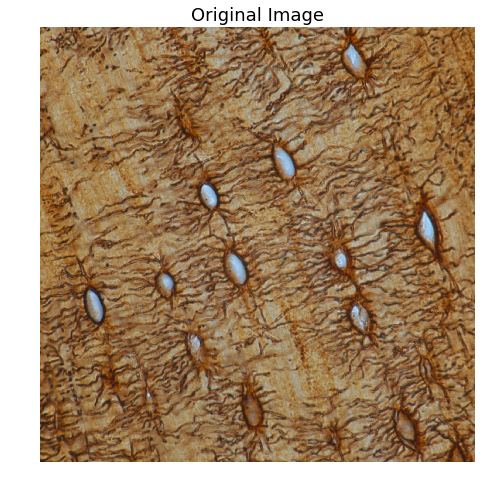

In [3]:
# Open Image 
path = list_of_paths[6]
org_image = imread(path)
gray_image = rgb2gray(org_image)
#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image,cmap='gray')
ax.set_axis_off()
plt.title("Original Image",fontsize='18')
plt.show()

A Jupyter Widget

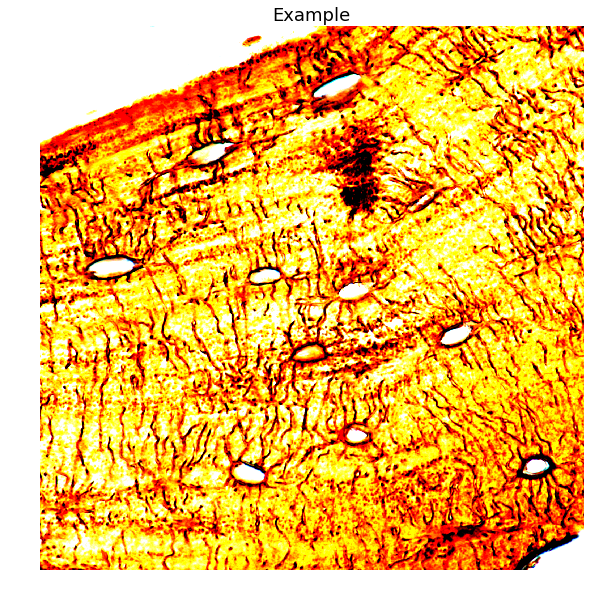

In [4]:
### 1st time just run ###
### 2nd time, enter exposure values from sliders below, then re-run cell to save
expose_low = 50
expose_high = 128

from skimage.exposure import rescale_intensity
image = (org_image)

# Rescale image intensity so lacuna are bright with dark outlines
@interact(low=(0,255,1), high =(0,255,1))

def rescale_image(low = expose_low, high = expose_high):
    f, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rescale_intensity(image, in_range=(low, high)))
    plt.title("Change Exposure using sliders until colors match example below",fontsize='18')
    plt.axis('off')
    plt.show()
    return

##### Example - Do NOT Edit #####
example_image = imread('/Users/charlieschurman/Desktop/GitHub/schurman-python-ay250-homeworks/final-project/example.jpg')
example_rescale = rescale_intensity(example_image, in_range=(70, 120))
#Plot 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(example_rescale,cmap='gray')
ax.set_axis_off()
plt.title("Example",fontsize='18')
plt.show()
##################################


image_rescale = rescale_intensity(image, in_range=(expose_low, expose_high))


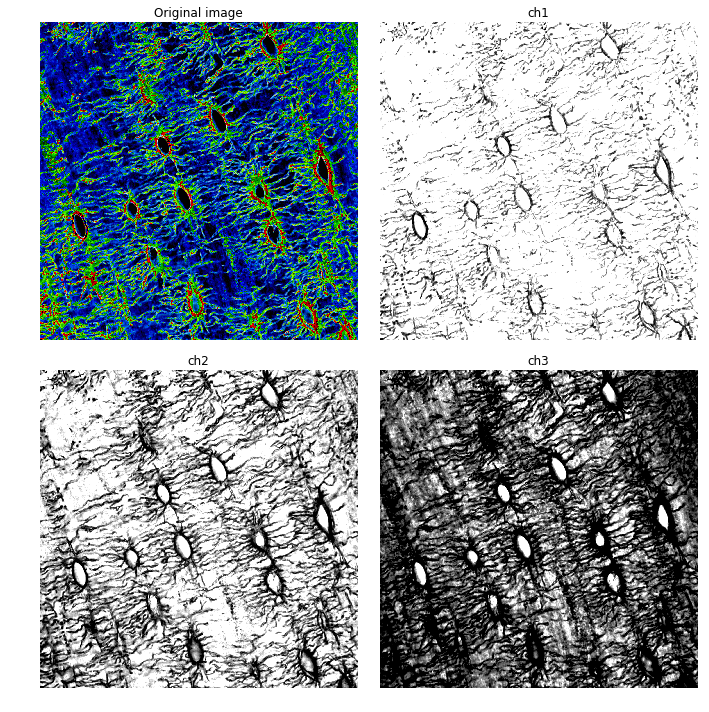

In [5]:
# Use Reconstruction/Erosion to enlarge the important features (boundaries around lacuna)
# Then use median filter to enhance contrast

image = image_rescale
seed = np.copy(image)
mask = image
filled = reconstruction(seed, mask, method='erosion')
img_med = ndi.median_filter(filled, size=5)

#plot filled-channels
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(filled,cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(filled[:, :, 0], cmap='gray')
ax[1].set_title("ch1")

ax[2].imshow(filled[:, :, 1], cmap='gray')
ax[2].set_title("ch2")

ax[3].imshow(filled[:, :, 2], cmap='gray')
ax[3].set_title("ch3")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

# The "orginal image" should have green on the dark features, blue on the bone, and only a little red
# change exposure window above until this is so
# This step is computationally expensive and takes a few seconds

# Create Lacunar Mask

A Jupyter Widget

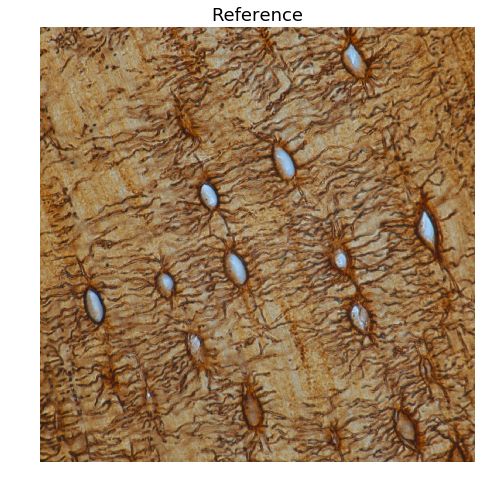

In [6]:
### Threshold Values 
### 1st time just run 
### 2nd time, enter exposure values from sliders below, then re-run cell to save
sig = 3
expand = 9
binary_threshold =235

# Take Channel 3 from filling to extract lacuna
ch3 = filled[:,:,2]
# some preprocessing
dilated = dilation(ch3)
erode = erosion(dilated)

# Find Values to Create Lacunar Mask

@interact(sigma=(1,10,.5), n_expand =(0,15,1), thresh = (0,260,5))
def lacunar_mask(sigma=sig, n_expand = expand, thresh = binary_threshold ):
    blurred = filters.gaussian(erode, sigma=sigma)
    lacuna = 1-(1*(blurred > thresh))
    count = 0
    while count < n_expand:
        lacuna = binary_dilation(lacuna)
        count += 1
    lacuna = binary_erosion(lacuna)
    lacuna = binary_erosion(lacuna)
    f, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(lacuna)
    plt.title("Lacunar Mask",fontsize='18')
    plt.axis('off')
    plt.show()
    return

#Plot reference
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(org_image,cmap='gray')
ax.set_axis_off()
plt.title("Reference",fontsize='18')
plt.show()

#Create Mask Based on Tested Values from sliders
blurred = filters.gaussian(erode, sigma=sig)
lacuna = 1-(1*(blurred > binary_threshold))
count = 0
while count < expand:
    lacuna = binary_dilation(lacuna)
    count += 1
lacuna = binary_erosion(lacuna)
lacuna = binary_erosion(lacuna)
lacuna = binary_erosion(lacuna)

# Create Enhanced Grey Scale Image

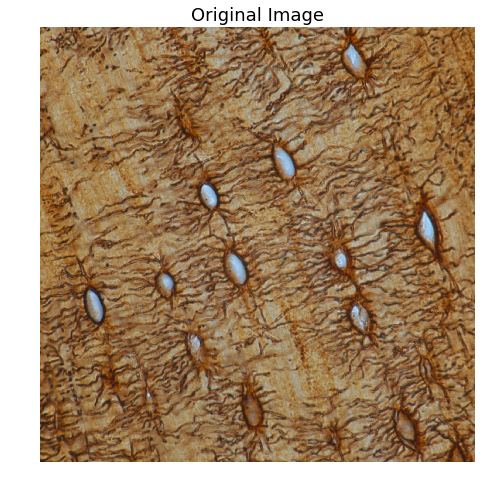

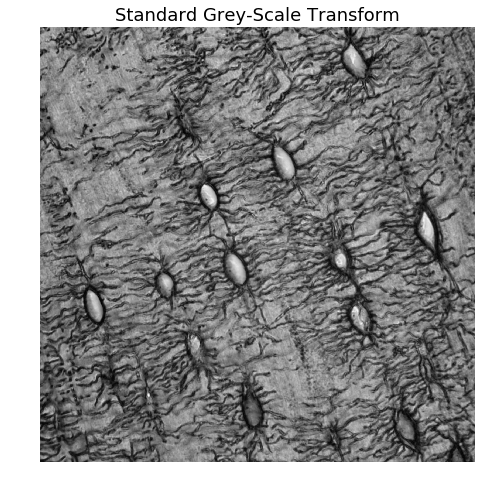

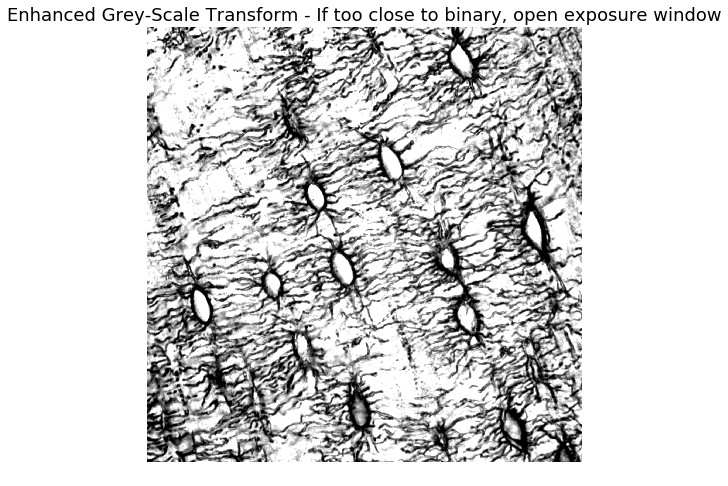

In [7]:
filt_gray_image = np.round(color.rgb2gray(img_med)).astype('int')

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image,cmap='gray')
ax.set_axis_off()
plt.title("Original Image",fontsize='18')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(gray_image,cmap='gray')
ax.set_axis_off()
plt.title("Standard Grey-Scale Transform",fontsize='18')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(filt_gray_image,cmap='gray')
ax.set_axis_off()
plt.title("Enhanced Grey-Scale Transform - If too close to binary, open exposure window",fontsize='18')
plt.show()

## Isolate Lacuna (Cell Bodies) For Measurements 

A Jupyter Widget

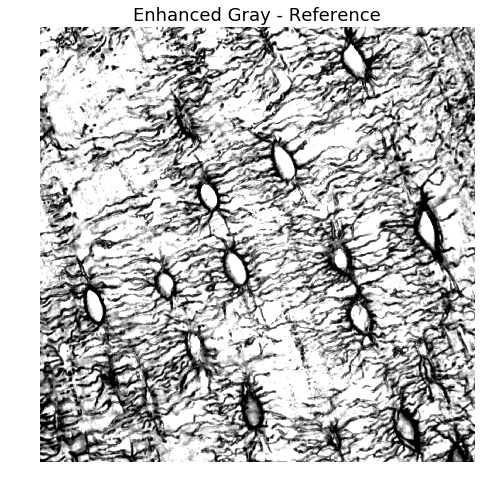

In [8]:
# Use slider to find appropriate threshold for isolating Lacuna (low binary), make sure cell bodies are completely enclosed
# and then threshold for total LCN (high binary)

thresh =141# <--- Change Value Here after testing with slider bar!

image = filt_gray_image

@interact(threshold=(0, 255, 1))
def filter_image(threshold=thresh):
    f, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(1*(image > threshold),cmap='gray')
    plt.title("Threshold Finder",fontsize='18')
    plt.axis('off')
    plt.show()

# Apply Binary Filter
binary = 1*(image > thresh) 

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(filt_gray_image,cmap='gray')
ax.set_axis_off()
plt.title("Enhanced Gray - Reference",fontsize='18')
plt.show()


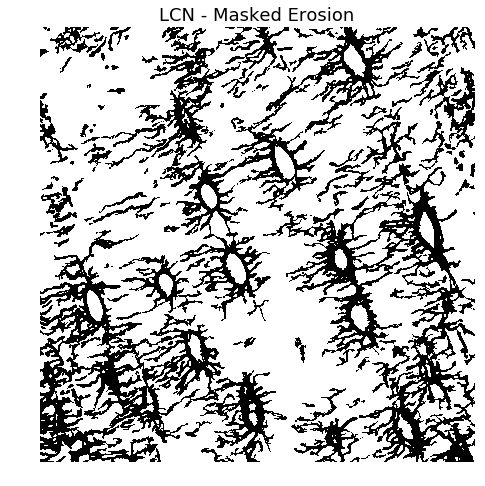

In [9]:
# Use the Binary a Mask for Erosion to remove small spots not removed by filtering up to now
mask = binary
seed = image
recon = reconstruction(seed, mask, method='erosion', selem=None, offset=None)
cleaned_binary = closing(recon)

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cleaned_binary,cmap='gray')
ax.set_axis_off()
plt.title("LCN - Masked Erosion",fontsize='18')
plt.show()


# Lacuna Indentification via scikit image labeling

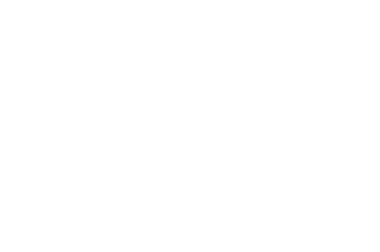

A Jupyter Widget

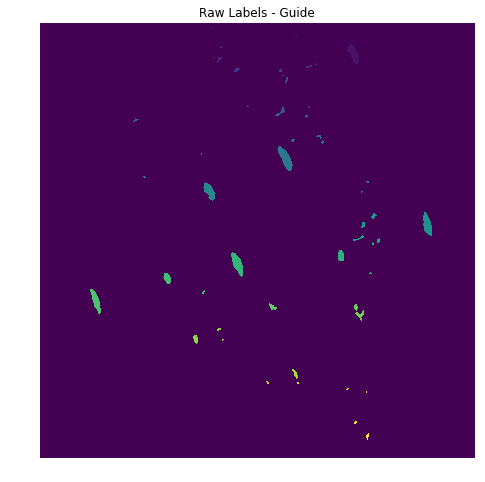

In [10]:
### Filtering Variables 
### 1st time just run 
### 2nd time, enter exposure values from sliders below, then re-run cell to save
circularity = 0.8
min_area = 1360
max_area = 15500

#Label based on Lacunar Mask
image_labels = label(1-lacuna)
image_rgb= label2rgb(image_labels)
meas_vals = regionprops(image_labels)
plt.axis('off')

@interact(eccentricity=(0,1,0.01), min_a = (0,8000,10), max_a =(0,20000,500))
#max area is to remove large features that are not lacuna

def find_lacuna(eccentricity = circularity, min_a = min_area, max_a = max_area):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(org_image,cmap='gray')
    for region in range(len(meas_vals)): 
        if meas_vals[region].eccentricity > eccentricity and meas_vals[region].area > min_a and meas_vals[region].area < max_a: 
            ax.plot(meas_vals[region].centroid[1],meas_vals[region].centroid[0], 'b*')
            
            
#The Raw Labels
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image_labels)
ax.set_axis_off()
plt.title('Raw Labels - Guide')
plt.show()



In [11]:
#Extract Measures using the Filtering Variables found/define above
eccen = []
areas = []
centroid = [] #will use the centroid points for plotting measured vals latter
regions = []

for region in range(len(meas_vals)): 
    if meas_vals[region].eccentricity > circularity and meas_vals[region].area > min_area and meas_vals[region].area < max_area: 
        regions.append(meas_vals[region])
        eccen.append(meas_vals[region].eccentricity)
        areas.append(meas_vals[region].area)
        centroid.append(meas_vals[region].centroid)

centroids = np.asarray(centroid)

# Identification of Lacuna based on Contours of the Lacunar Mask


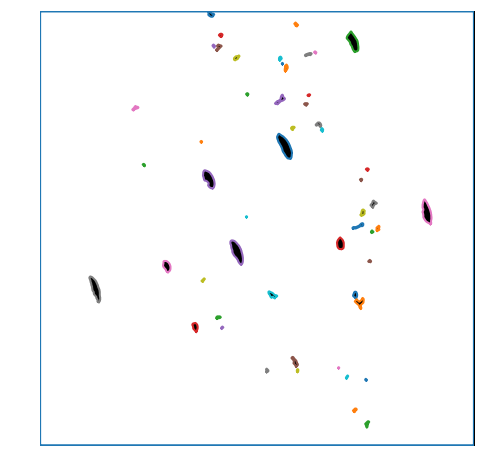

In [12]:
# Find Contours of Lacuna based on the Lacunar Mask
inv_lacuna = 1 - lacuna
contours = find_contours(inv_lacuna, .9)
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(lacuna, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.axis('off')
    
    

# Fit Convex Hulls to filtered contours

A Jupyter Widget

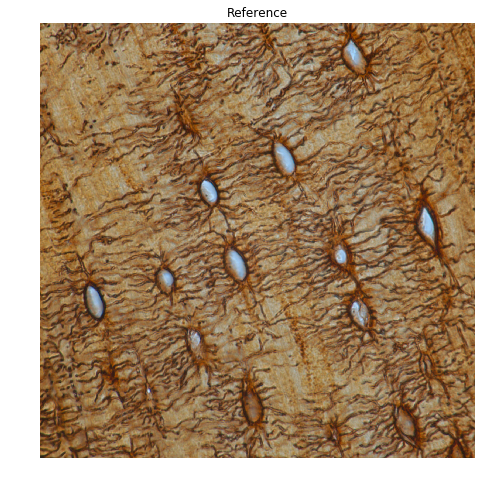

In [70]:
#Filtering Variables
min_volume = 600 # recursively edit this manually
max_area = 1000
@interact(min_volume=(0,5000,50),max_area=(0,5000,50))
#max area is to remove large features that are not lacuna

def rescale_image(min_volume = min_volume, max_area = max_area):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(lacuna, interpolation='nearest', cmap='gray')
    plt.axis('off')
    
    for n, contour in enumerate(contours):
        hull = ConvexHull(contours[n])
        if hull.volume > min_volume and hull.area < max_area:
            ax.plot(contours[n][hull.vertices,1], contours[n][hull.vertices,0], 'r--', lw=2)
            ax.plot(contours[n][hull.vertices[1],1], contours[n][hull.vertices[1],0], 'ro')
            plt.title('Convex Hulls ')
    return

# Plot reference
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image, interpolation='nearest', cmap='gray')
plt.title('Reference')
plt.axis('off')
plt.show()


In [71]:
# Filtering Variables
# Extract values from the convex hulls at the found/defined cut-offs

hulls=[] #Initiate collector variables
centroid=[]
comp = recon 
cont_pointsX = []
cont_pointsY = []
for n, contour in enumerate(contours):
    hull = ConvexHull(contours[n])
    if hull.volume > min_volume and hull.area < max_area:
        hulls.append(hull) # <-- collect
        cont_point_x=contours[n][hull.vertices,1]
        cont_point_y=contours[n][hull.vertices,0]
        cont_pointsX.append(cont_point_x)
        cont_pointsY.append(cont_point_y)
        x=np.mean(contours[n][hull.vertices,1])
        y=np.mean(contours[n][hull.vertices,0])
        centroid.append([x,y])

#extract the coordinates of the points for the hulls
XS=[]
YS=[]
for N in range(len(cont_pointsX)):
    for M in range(len(cont_pointsX[N])):
        XS.append(np.round(cont_pointsX[N][M]))
        YS.append(np.round(cont_pointsY[N][M]))
XS=np.asarray(XS)
YS=np.asarray(YS)

# Fit Ellipses to the identified convex hulls

In [72]:
# Fit Ellipses to the convex hulls adapted from http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

from numpy.linalg import eig, inv

def fitEllipse(x,y):
    '''Fit ellipse to set of points X,Y'''
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(E)
    a = V[:,n]
    
    return a

def ellipse_center(a):
    '''Find the center of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation(a):
    '''Find the angle of rotation (in radians) of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length(a):
    '''Find the lengths of the bounding axes of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])


# Plot the fitted Ellipses over the Binary Image
## This is done to create new images with and without the lacuna and the rest of the network

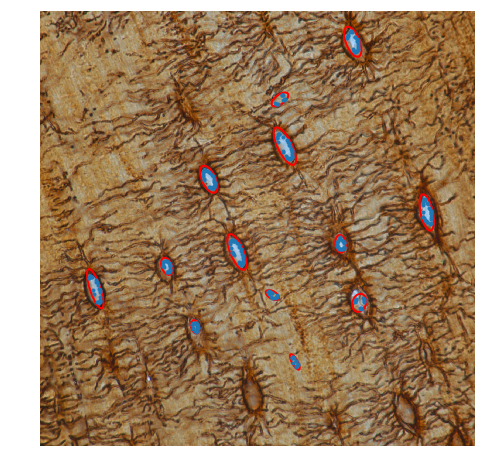

In [92]:
from matplotlib.patches import Ellipse
#3 types are generated, outlines for overlay on original image, and black and white filled ellipses for use with binary image

ellipse=[]
for n in range(len(cont_pointsX)):
    a = fitEllipse(cont_pointsX[n],cont_pointsY[n])
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a)
    
#Generate the Ellipse Patch object for plotting
    
    ellipse.append(Ellipse(center, width=axes[0]*3, height=axes[1]*3, angle=phi*(180/np.pi), #angle for plotting is in deg, convert from radian
                        edgecolor='r', fc='None', lw=2))
# Overlay
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image)
ax.plot(XS,YS,'.') #fitted points
for e in ellipse:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
plt.axis('off')
plt.show()


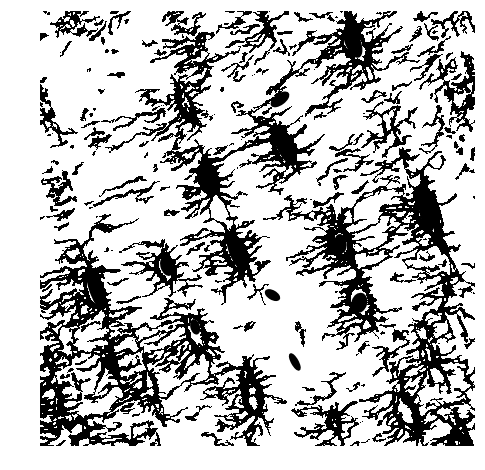

In [93]:
ellipseK=[]
for n in range(len(cont_pointsX)):
    a = fitEllipse(cont_pointsX[n],cont_pointsY[n])
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a) 
    ellipseK.append(Ellipse(center, width=axes[0]*3, height=axes[1]*3, angle=phi*(180/np.pi), #angle for plotting is in deg, convert from radian
                        edgecolor='k', fc='k', lw=2))
    #filled Elipses, used for masking later

#LCN from Black Ellipses
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(cleaned_binary,interpolation='none',cmap='gray')
for e in ellipseK:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
plt.axis('off')
plt.savefig("LCN.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)

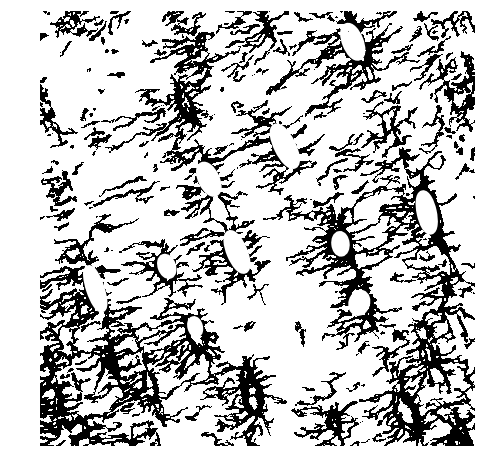

In [94]:
#White Ellipses
ellipseW=[]
for n in range(len(cont_pointsX)):
    a = fitEllipse(cont_pointsX[n],cont_pointsY[n])
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a)

    ellipseW.append(Ellipse(center, width=axes[0]*3, height=axes[1]*3, angle=phi*(180/np.pi), 
                        edgecolor='w', fc='None', lw=8)) 
    #filled Elipses, used for masking later
    
#Canaliculi Only, White Ellipses
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(cleaned_binary,interpolation='none',cmap='gray')
for e in ellipseW:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
plt.axis('off')
plt.savefig("Cans.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)



## Find LCN and Canalicular Area


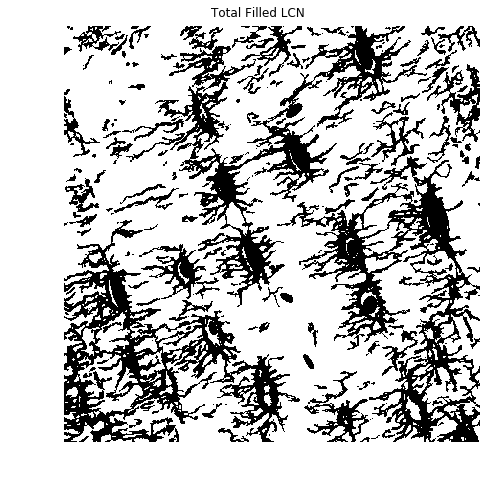

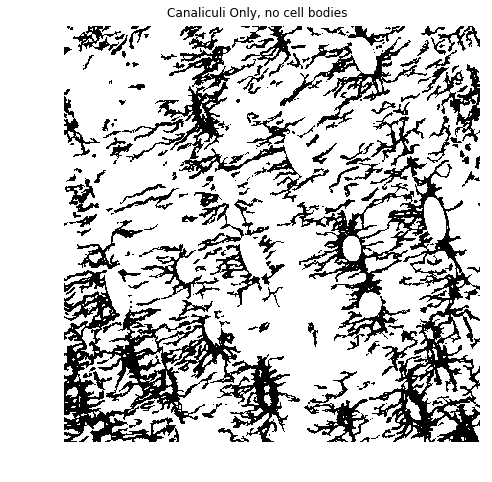

In [95]:
LCN = imread("LCN.png")
LCN = rgb2gray(LCN)
LCN = 1*(LCN > 0)

CAN = imread("Cans.png")
CAN = rgb2gray(CAN)
CAN = 1*(CAN > 0)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(LCN, interpolation='nearest', cmap=plt.cm.gray, )
plt.axis('off')
plt.title('Total Filled LCN')

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(CAN, interpolation='nearest', cmap=plt.cm.gray, )
plt.axis('off')
plt.title('Canaliculi Only, no cell bodies')
plt.show()

## Math!!! and Assemble Output
Fairly Simple once the images are cleaned

In [96]:
#loop over the pixels in the image, if they are black, add to sum
#not most efficient way, but was having issues with the sum() command
can_sum = 0
for i in range(CAN.shape[0]):
    for j in range(CAN.shape[1]):
        if CAN[i,j] == 0:
            can_sum += 1
            
LCN_sum = 0
for i in range(LCN.shape[0]):
    for j in range(LCN.shape[1]):
        if LCN[i,j] == 0:
            LCN_sum += 1
            
Lacuna_sum = 0
for i in range(LCN.shape[0]):
    for j in range(LCN.shape[1]):
        if LCN[i,j] != CAN[i,j]:
            Lacuna_sum += 1


In [97]:
#Express sums in terms of percent (since we have no scale bars)
#Find rest of wanted values

can_area = can_sum/(CAN.shape[0]*CAN.shape[1])
LCN_area = LCN_sum/(LCN.shape[0]*LCN.shape[1])
lacunar_area = Lacuna_sum/(LCN.shape[0]*LCN.shape[1])
lac_num = len(hulls)
avg_lac_area = lacunar_area/lac_num

#Parse file name
parts = path.split('/')
animal = parts[-2]
file_name = parts[-1]
result=[animal,file_name, lac_num, lacunar_area, avg_lac_area, can_area, LCN_area]

In [87]:
results.append(result)

In [88]:
# Organize Extracted Features
columns=['animal', 'file_name', 'lac_num', 'lacunar_area', 'avg_lac_area', 'can_area', 'LCN_area']


In [89]:
all_vals = pd.DataFrame(results,columns=columns)

In [85]:
#Ready Export Variable
#only run this once, or you'll wipe all your data later
results=[]


In [98]:
all_vals
#repeat for multiple images

animal         file_name  lac_num  lacunar_area  avg_lac_area  can_area  \
0     WT  2322B-100x-4.jpg       13      0.028707      0.002208  0.249647   

   LCN_area  
0  0.278354